## 1. Importing libraries


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
torch.__version__

'2.6.0+cu124'

In [ ]:
torchvision.__version__

'0.21.0+cu124'

## 2. Setup Device-Agnostic Code

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(f"Using device: {device}")

cuda
Using device: cuda


## 3. Set the seed

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

## 4. Setting the hyperparameters

In [ ]:
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 3e-4
IMAGE_SIZE = 32
PATCH_SIZE = 4            # 8x8 patches → 64 tokens
CHANNELS = 3
NUM_CLASSES = 10
EMBED_DIM = 192
DEPTH = 6
NUM_HEADS = 6             # 192/6 = 32
MLP_DIM = 384             # 2x EMBED_DIM
DROP_RATE = 0.1


##5. Define Image Transformations

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
    #helps the module to coverge faster
    #helps to make the numerical computations stable
])

## 6. Importing dataset from CIFAR10

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 43.5MB/s]


In [ ]:
test_dataset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

In [ ]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [ ]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [ ]:
len(train_dataset)

50000

In [ ]:
len(test_dataset)

10000

##7. Converting our datasets into dataloaders

Currently, our data is in the form of PyTorch datasets.
DataLoader turns our data into batches or (mini-batches).
Because it is more computationally effficient and it gives our nn mroe chances to update its gradients per epoch.

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Let's check what we have created

In [ ]:
print(f"Length of train_loader: {len(train_loader)} batches of {BATCH_SIZE}")
print(f"Length of test_loader: {len(test_loader)} batches of {BATCH_SIZE}")

Length of train_loader: 391 batches of 128
Length of test_loader: 79 batches of 128


## 8. Building Vision Transformer Model from scratch

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self, img_size, patch_size, in_channels, embed_dim):
    super().__init__()
    self.patch_size = patch_size
    self.proj = nn.Conv2d(in_channels=in_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)
    num_patches = (img_size // patch_size) ** 2
    self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

  def forward(self, x: torch.Tensor):
    B = x.size(0)  # batch size
    x = self.proj(x)  # shape: [B, embed_dim, H', W']
    x = x.flatten(2).transpose(1, 2)

    # Expand cls_token to match batch size
    cls_token = self.cls_token.expand(B, -1, -1)

    # Concatenate class token at the beginning
    x = torch.cat((cls_token, x), dim=1)  # shape: [B, num_patches + 1, embed_dim]

    # Add positional embeddings
    x = x + self.pos_embed

    return x


In [ ]:
class MLP(nn.Module):
  def __init__(self,
               in_features,
               hidden_features,
               drop_rate):
    super().__init__()
    self.fc1 = nn.Linear(in_features = in_features,
                         out_features = hidden_features)
    self.fc2 = nn.Linear(in_features=hidden_features,
                         out_features=in_features)
    self.dropout = nn.Dropout(drop_rate)

  def forward(self, x):
    x = self.dropout(F.gelu(self.fc1(x))) # Added x to fc1 and parentheses
    x = self.dropout(self.fc2(x)) # Added x to fc2 and parentheses
    return x

In [ ]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
    super().__init__()
    self.norm1 = nn.LayerNorm(embed_dim)
    self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

  def forward(self, x):
    x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0] # Corrected second argument of self.attn
    x = x + self.mlp(self.norm2(x))
    return x

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
    super().__init__()
    self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
    self.encoder = nn.Sequential(
    *[TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate) for _ in range(depth)]
)
    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, num_classes)

  def forward(self, x):
    x = self.patch_embed(x)
    x = self.encoder(x)
    x = self.norm(x)
    cls_token = x[:, 0]
    x = self.head(cls_token)
    return x

In [ ]:
DEPTH

6

In [ ]:
device

device(type='cuda')

In [ ]:
model = VisionTransformer(IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES, EMBED_DIM, DEPTH, NUM_HEADS, MLP_DIM, DROP_RATE).to(device)

#Model Architecture

In [ ]:
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
      )
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=192, out_features=384, bias=True)
        (fc2): Linear(in_features=384, out_features=192, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
      )
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP

##9. Defining a loss function and an optimizer


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
criterion
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

## 10. Defining a training loop function

In [ ]:
def train(model, train_loader, criterion):
    model.train()
    total_loss, correct = 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()

    return total_loss / len(train_loader.dataset), correct / len(train_loader.dataset)

In [ ]:
def evaluate(model, test_loader):
  model.eval() #set the mode to evaluation for the model
  correct = 0
  with torch.inference_mode():
    for x,y in test_loader:
      x,y = x.to(device), y.to(device)
      out = model(x)
      correct += (out.argmax(1) == y).sum().item()
  return correct / len(test_loader.dataset)

In [ ]:
from tqdm.auto import tqdm

In [ ]:
### Training

train_accuracies = []
test_accuracies = []

for epoch in tqdm(range(EPOCHS)):
  train_loss, train_acc = train(model, train_loader, criterion)
  test_acc = evaluate(model, test_loader)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)
  print(f"Epoch: {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10, Train Loss: 1.7421, Train Acc: 0.3705, Test Acc: 0.4705
Epoch: 2/10, Train Loss: 1.4196, Train Acc: 0.4905, Test Acc: 0.5296
Epoch: 3/10, Train Loss: 1.2770, Train Acc: 0.5429, Test Acc: 0.5726
Epoch: 4/10, Train Loss: 1.1782, Train Acc: 0.5783, Test Acc: 0.5686
Epoch: 5/10, Train Loss: 1.0993, Train Acc: 0.6051, Test Acc: 0.5952
Epoch: 6/10, Train Loss: 1.0292, Train Acc: 0.6331, Test Acc: 0.6051
Epoch: 7/10, Train Loss: 0.9612, Train Acc: 0.6572, Test Acc: 0.6101
Epoch: 8/10, Train Loss: 0.9010, Train Acc: 0.6787, Test Acc: 0.6272
Epoch: 9/10, Train Loss: 0.8367, Train Acc: 0.7013, Test Acc: 0.6252
Epoch: 10/10, Train Loss: 0.7741, Train Acc: 0.7246, Test Acc: 0.6274


In [ ]:
print(f"Train Acc: {train_accuracies}")
print(f"Test Acc: {train_accuracies}")

Train Acc: [0.37054, 0.49046, 0.54292, 0.5783, 0.6051, 0.63312, 0.65722, 0.67872, 0.70134, 0.72458]
Test Acc: [0.37054, 0.49046, 0.54292, 0.5783, 0.6051, 0.63312, 0.65722, 0.67872, 0.70134, 0.72458]


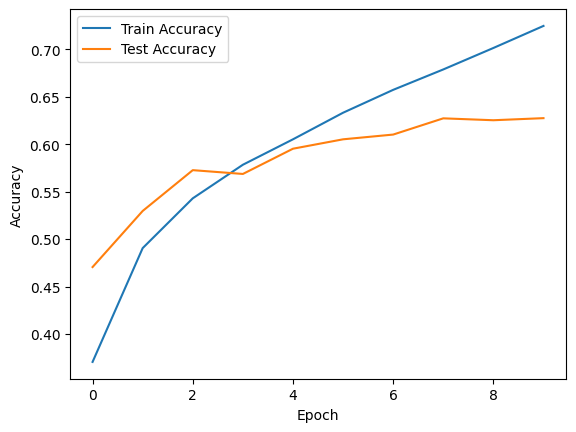

In [ ]:
# Plot the accuracy
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import random

In [ ]:
def predict_and_plot_grid(model, dataset, classes, grid_size=3):

    model.eval()
    device = next(model.parameters()).device

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset) - 1)
            img, true_label = dataset[idx]

            input_tensor = img.unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(input_tensor)

            pred = output.argmax(1).item()

            img_disp = img.cpu() * 0.2470 + 0.4914  # Roughly de-normalize CIFAR-10
            npimg = img_disp.numpy()

            axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
            is_correct = (classes[pred] == classes[true_label])
            axes[i, j].set_title(f"True: {classes[true_label]}\nPred: {classes[pred]}",
                                 color="green" if is_correct else "red")
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()


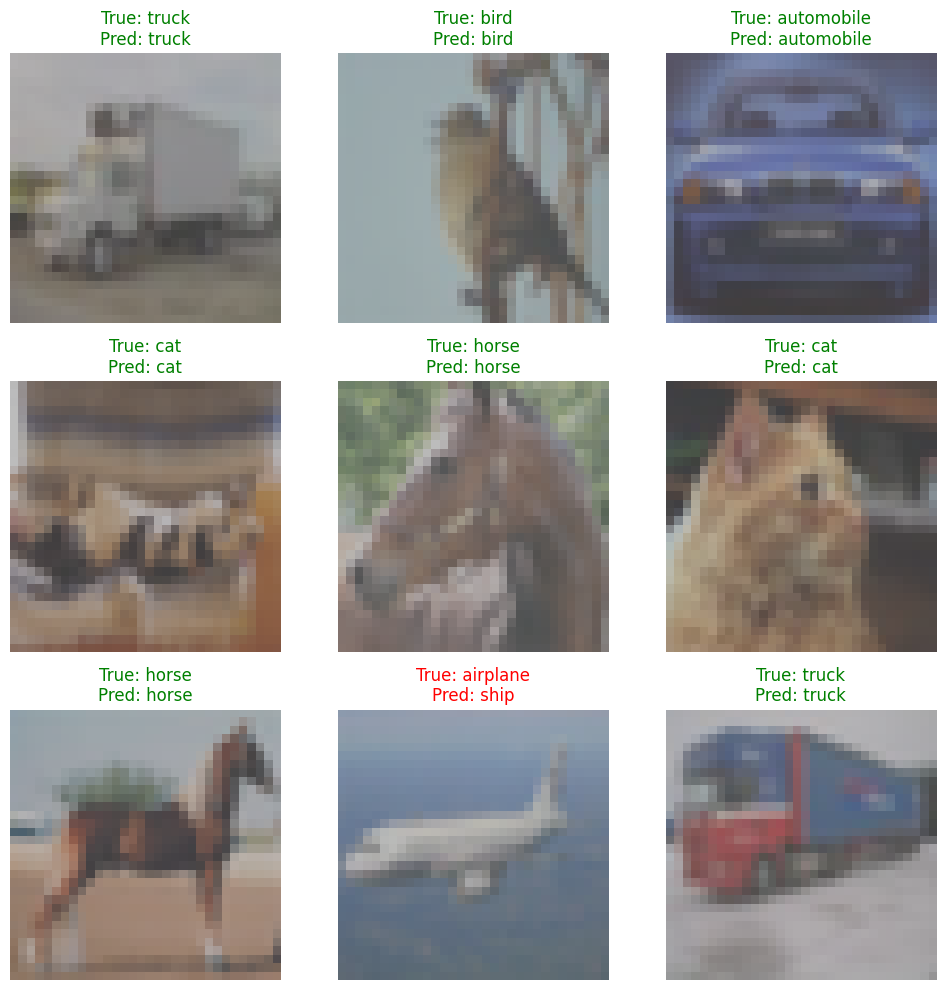

In [ ]:
predict_and_plot_grid(model, test_dataset, classes=train_dataset.classes, grid_size=3)